# Linear models - Preprocessing

In this notebook, we will discuss the importance of preprocessing in linear models, especially when the solver used rely on gradient-based optimization method.

In [1]:
# temporary fix to avoid spurious warning raised in scikit-learn 1.0.0
# it will be solved in scikit-learn 1.0.1
import warnings
warnings.filterwarnings("ignore", message="X has feature names.*")
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

## Importance of data scaling

Since we would like to demonstrate issue related to gradient-based optimization solver, we will need to use a linear model that does not rely on an algorithm that provide a closed-form solution. Such algorithm is `LogisticRegression` for instance (in the contrary to `LinearRegression` or `Ridge`).

Thus, let's start by loading our penguins dataset to distinguish the different species.

In [2]:
import pandas as pd

data = pd.read_csv("../datasets/penguins_classification.csv")
target_name = "Species"
X = data.drop(columns=target_name)
y = data[target_name]

Up to now, we did not bother much about evaluating our model: we used a single dataset just to illustrate some fitting property of the different estimators. However, the preprocessing that we are going to use need to be applied in a specific manner depending if one is training or testing a model. Therefore, we will start by using a training and testing set.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)
X_train.head()

,Culmen Length (mm),Culmen Depth (mm)
306,42.5,16.7
101,37.7,16.0
153,48.7,14.1
341,50.2,18.7
81,36.7,18.8


Previously, we showed that we could train a `LogisticRegression` model in the following manner.

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9767441860465116

We previously stated that this model is minimizing a specific loss function (log loss). However, we did not mentioned what algorithm was used to find the optimal parameters $\beta$ that minimize this log loss. We only discuss such details with `LinearRegression` where we used the Normal equation that is a closed-form solution to the least squared minimization.

For the `LogisticRegression`, the problem does not have a closed-form solution. Instead, the different algorithms rely on the derivatives of the log loss to find the best parameter. One can check the available algorithm looking at the documentation of the `solver` parameter: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

All the different solvers rely on derivatives of the log loss, meaning that an iterative algorithm will take place to find the optimal parameters of the model. Therefore, once the `LogisticRegression` is fitted, we can know the number of iteration that an algorithm did to find the optimal parameters.

In [5]:
model.n_iter_

array([74], dtype=int32)

However, there is something that is not really proper regarding our training dataset. We can have a look to our dataset

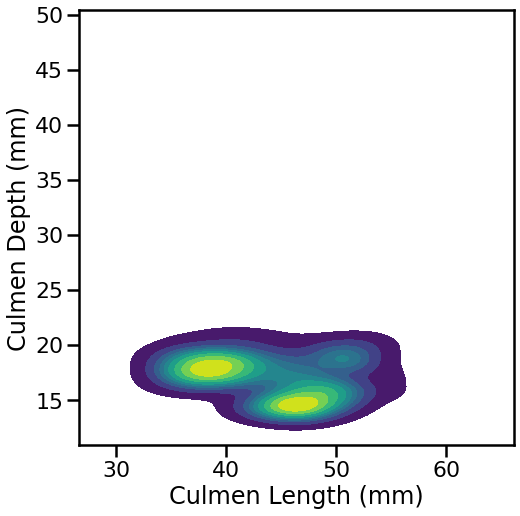

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

_, ax = plt.subplots(figsize=(8, 8))
ax = sns.kdeplot(
    data=X_train,
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    levels=10,
    fill=True,
    cmap=plt.cm.viridis,
    ax=ax,
)
_ = ax.axis("square")

Looking at our data distribution, we observed that the deviation from the mean is more important for the culmen length feature than the culmen depth feature. This will have an impact when dealing with gradient-based model.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Using pandas, rescale the dataset such that they will be centered to (0, 0) and have a unit standard deviation for both feature.</li>
        <li>Plot the distribution of the data as previously done.</li>
        <li>Fit a <tt>LogisticRegression</tt> on the scaled dataset.</li>
        <li>Check the number of iterations needed to train the model.</li>
    </ul>
</div>

In [7]:
X_train_scaled = (X_train - X_train.mean()) / X_train.std()

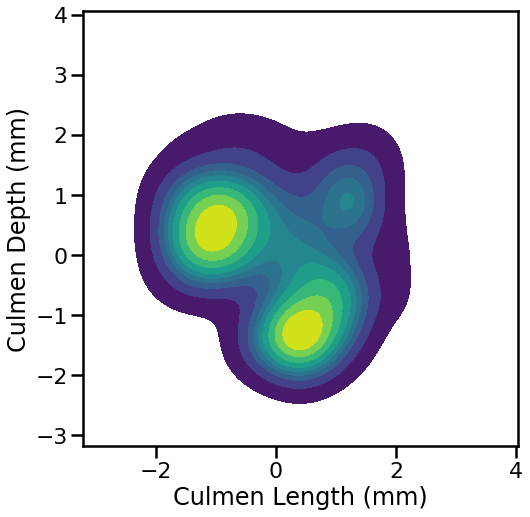

In [8]:
_, ax = plt.subplots(figsize=(8, 8))
ax = sns.kdeplot(
    data=X_train_scaled,
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    levels=10,
    fill=True,
    cmap=plt.cm.viridis,
    ax=ax,
)
_ = ax.axis("square")

In [9]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
model.n_iter_

array([14], dtype=int32)

## Scikit-learn transformers API

There is a family of estimator in scikit-learn that allows to "transform" data. As predictor, they can learn some states during `fit` and later reuse these states when calling the method `transform`. Let's perform the previous scaling using the `StandardScaler` transformer from scikit-learn.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

As stated, we expect our scaler to have some state after calling `fit`. Indeed, our scaler will have store the mean and standard deviation of the dataset.

In [11]:
scaler.mean_, scaler.scale_

(array([44.11640625, 17.046875  ]), array([5.44877104, 1.92943634]))

Now we can use the `transform` method to scale the data.

In [12]:
X_train_scaled = scaler.transform(X_train)
# scikit-learn will transform any pandas dataframe into a NumPy array
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head()

,Culmen Length (mm),Culmen Depth (mm)
0,-0.296655,-0.179780
1,-1.177588,-0.542581
2,0.841216,-1.527324
3,1.116508,0.856792
4,-1.361115,0.908620


Let's plot the distribution of the data to convince ourself that the transformation applied is the same than we did by hand earlier.

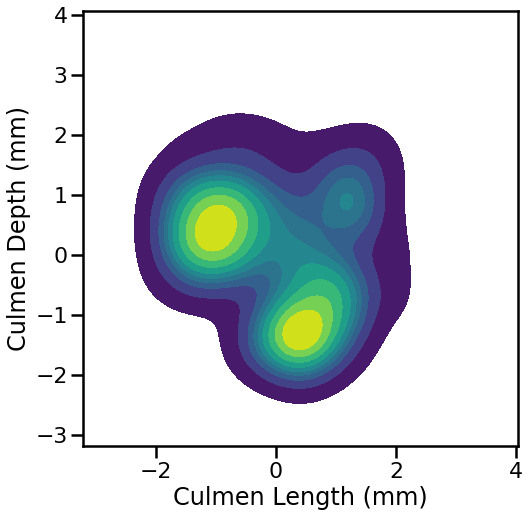

In [13]:
_, ax = plt.subplots(figsize=(8, 8))
ax = sns.kdeplot(
    data=X_train_scaled,
    x="Culmen Length (mm)",
    y="Culmen Depth (mm)",
    levels=10,
    fill=True,
    cmap=plt.cm.viridis,
    ax=ax,
)
_ = ax.axis("square")

In [14]:
X_train_scaled.mean()

Culmen Length (mm)    5.620504e-16
Culmen Depth (mm)     5.898060e-17
dtype: float64

In [15]:
X_train_scaled.std()

Culmen Length (mm)    1.001959
Culmen Depth (mm)     1.001959
dtype: float64

The advantage of using scikit-learn transformer over manually manipulating the dataset is that we can make complex pipeline. A pipeline can be represented as a sequence of scikit-learn transformers finishing by a scikit-learn predictor. This pipeline will have the same API than a scikit-learn predictor (i.e. `fit`, `predict`, `predict_proba`, `decision_function`), and will take care of the transformation and the transformation state for us.

Let's define such of a scikit-learn pipeline.

In [16]:
import sklearn
# to make nice diagram when plotting complex pipeline
sklearn.set_config(display="diagram")

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Here, we created a pipeline that will be in charge of scaling the data first and then pass it to the classifier. Let's demonstrate how to train this pipeline.

In [18]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

We just trained our model without the need to take care about the scaling ourselve. We can check that model have internal state learnt during `fit`. Let's first check our scaler.

In [19]:
model[0].mean_, model[0].scale_

(array([44.11640625, 17.046875  ]), array([5.44877104, 1.92943634]))

So the first step of the pipeline stored the mean and standard deviation of the training set. Did we learn the optimal parameter of the `LogisticRegression`?

In [20]:
model[-1].coef_

array([[-2.87194706,  2.22608624],
       [ 1.03286407,  0.84888563],
       [ 1.83908299, -3.07497187]])

Apparently, we did. We can even check the number of iteration that it took to train the model.

In [21]:
model[-1].n_iter_

array([14], dtype=int32)

So the pipeline did all the job that we previously manually did with the advantage that it exposes the same API than any predictor that we used up to now. What about prediction and scoring?

Indeed, during prediction, we would need to scale the testing set using the statistic found during training. Using the pipeline with the `predict` method will take care of this processing for us.

In [22]:
y_pred = model.predict(X_test)

In [23]:
(y_test == y_pred).mean()

0.9883720930232558

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    In the first course, we saw that we could pass a model to <tt>cross_validate</tt> to get a distrbution of score.
    Use the previous complex pipeline, and evaluate it using the <tt>cross_validate</tt> function.
</div>

## Side effect of longer processing

We would like to trigger a behaviour that you could encounter in scikit-learn. It is quite important to know what it means and how to act. Let's load a dataset first.

In [24]:
data = pd.read_csv("../datasets/adult-census-numeric-all.csv")
data.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,class
0,25,7,0,0,40,<=50K
1,38,9,0,0,50,<=50K
2,28,12,0,0,40,>50K
3,44,10,7688,0,40,>50K
4,18,10,0,0,30,<=50K


In [25]:
target_name = "class"
X = data.drop(columns=target_name)
y = data[target_name]

This dataset is linked to a classification task.

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Fit a <tt>LogisticRegression</tt> algorithm without scaling the data first. In addition, force the maximum number of iteration of the solver to be at most 50 iterations. What is the result of the training?
</div>

In [26]:
model = LogisticRegression(max_iter=50)
model.fit(X, y)

/Users/glemaitre/mambaforge/envs/teaching/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=50)

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    Implement both proposals stipulated in the warning message and argument which option you should choose and why?
</div>

In [27]:
model.set_params(max_iter=1_000)
model.fit(X, y)

LogisticRegression(max_iter=1000)

In [28]:
model.n_iter_

array([100], dtype=int32)

In [29]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [30]:
pipe[-1].n_iter_

array([13], dtype=int32)

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    What is the impact of using a scaler on the coefficient?
</div>

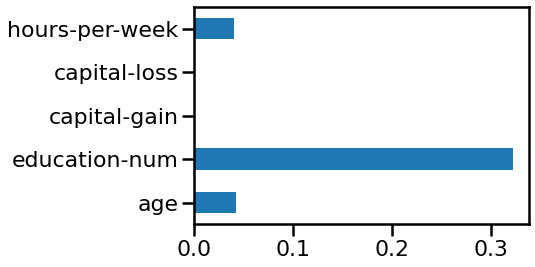

In [31]:
coef = pd.Series(model.coef_[0], index=X.columns)
_ = coef.plot.barh()

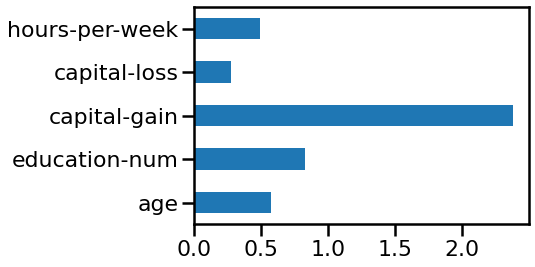

In [32]:
coef = pd.Series(pipe[-1].coef_[0], index=X.columns)
_ = coef.plot.barh()